In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os

# TO USE A DATABASE OTHER THAN SQLITE, USE THIS LINE
# Note that this is necessary for parallel execution amongst other things...
# os.environ['SNORKELDB'] = 'postgres:///snorkel-intro'

from snorkel import SnorkelSession
session = SnorkelSession()

# Here, we just set how many documents we'll process for automatic testing- you can safely ignore this!
n_docs = 500 if 'CI' in os.environ else 2591

from snorkel.models import candidate_subclass

Spouse = candidate_subclass('Spouse', ['person1', 'person2'])

train_cands = session.query(Spouse).filter(Spouse.split == 0).order_by(Spouse.id).all()
dev_cands   = session.query(Spouse).filter(Spouse.split == 1).order_by(Spouse.id).all()
test_cands  = session.query(Spouse).filter(Spouse.split == 2).order_by(Spouse.id).all()


In [2]:
from util import load_external_labels

#%time load_external_labels(session, Spouse, annotator_name='gold')

from snorkel.annotations import load_gold_labels

#L_gold_dev  = load_gold_labels(session, annotator_name='gold', split=1, zero_one=True)
#L_gold_test = load_gold_labels(session, annotator_name='gold', split=2, zero_one=True)

L_gold_dev  = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)

In [59]:
#gold_labels_dev = [x[0,0] for x in L_gold_dev.todense()]
#for i,L in enumerate(gold_labels_dev):
#    print(i,gold_labels_dev[i])

gold_labels_dev = []
for i,L in enumerate(L_gold_dev):
    gold_labels_dev.append(L[0,0])
    
gold_labels_test = []
for i,L in enumerate(L_gold_test):
    gold_labels_test.append(L[0,0])
    
print(len(gold_labels_dev),len(gold_labels_test))
print(gold_labels_dev.count(1),gold_labels_dev.count(-1))

2796 2697
196 2600


In [3]:
from gensim.parsing.preprocessing import STOPWORDS
import gensim.matutils as gm

from gensim.models.keyedvectors import KeyedVectors

# Load pretrained model (since intermediate data is not included, the model cannot be refined with additional data)
model = KeyedVectors.load_word2vec_format('../glove_w2v.txt', binary=False)  # C binary format


wordvec_unavailable= set()
def write_to_file(wordvec_unavailable):
    with open("wordvec_unavailable.txt","w") as f:
        for word in wordvec_unavailable:
            f.write(word+"\n")

def preprocess(tokens):
    btw_words = [word for word in tokens if word not in STOPWORDS]
    btw_words = [word for word in btw_words if word.isalpha()]
    return btw_words

def get_word_vectors(btw_words): # returns vector of embeddings of words
    word_vectors= []
    for word in btw_words:
        try:
            word_v = np.array(model[word])
            word_v = word_v.reshape(len(word_v),1)
            #print(word_v.shape)
            word_vectors.append(model[word])
        except:
            wordvec_unavailable.add(word)
    return word_vectors

def get_similarity(word_vectors,target_word): # sent(list of word vecs) to word similarity
    similarity = 0
    target_word_vector = 0
    try:
        target_word_vector = model[target_word]
    except:
        wordvec_unavailable.add(target_word+" t")
        return similarity
    target_word_sparse = gm.any2sparse(target_word_vector,eps=1e-09)
    for wv in word_vectors:
        wv_sparse = gm.any2sparse(wv, eps=1e-09)
        similarity = max(similarity,gm.cossim(wv_sparse,target_word_sparse))
    return similarity


In [7]:
##### Continuous ################

softmax_Threshold = 0.3
LF_Threshold = 0.3

import re
from snorkel.lf_helpers import (
    get_left_tokens, get_right_tokens, get_between_tokens,
    get_text_between, get_tagged_text,
)


spouses = {'spouse', 'wife', 'husband', 'ex-wife', 'ex-husband'}
family = {'father', 'mother', 'sister', 'brother', 'son', 'daughter',
              'grandfather', 'grandmother', 'uncle', 'aunt', 'cousin'}
family = family | {f + '-in-law' for f in family}
other = {'boyfriend', 'girlfriend' 'boss', 'employee', 'secretary', 'co-worker'}

# Helper function to get last name
def last_name(s):
    name_parts = s.split(' ')
    return name_parts[-1] if len(name_parts) > 1 else None    

def LF_husband_wife(c):
    global LF_Threshold
    sc = 0
    word_vectors = get_word_vectors(preprocess(get_between_tokens(c)))
    for sw in spouses:
        sc=max(sc,get_similarity(word_vectors,sw))
    return (1,sc)

def LF_husband_wife_left_window(c):
    global LF_Threshold
    sc_1 = 0
    word_vectors = get_word_vectors(preprocess(get_left_tokens(c[0])))
    for sw in spouses:
        sc_1=max(sc_1,get_similarity(word_vectors,sw))
        
    sc_2 = 0
    word_vectors = get_word_vectors(preprocess(get_left_tokens(c[1])))
    for sw in spouses:
        sc_2=max(sc_2,get_similarity(word_vectors,sw))
    return(1,max(sc_1,sc_2))
    
def LF_same_last_name(c):
    p1_last_name = last_name(c.person1.get_span())
    p2_last_name = last_name(c.person2.get_span())
    if p1_last_name and p2_last_name and p1_last_name == p2_last_name:
        if c.person1.get_span() != c.person2.get_span():
            return (1,1)
    return (0,0)

def LF_no_spouse_in_sentence(c):
    return (-1,0.75) if np.random.rand() < 0.75 and len(spouses.intersection(c.get_parent().words)) == 0 else (0,0)

def LF_and_married(c):
    global LF_Threshold
    word_vectors = get_word_vectors(preprocess(get_right_tokens(c)))
    sc = get_similarity(word_vectors,'married')
    
    if 'and' in get_between_tokens(c):
        return (1,sc)
    else:
        return (0,0)

def LF_familial_relationship(c):
    global LF_Threshold
    sc = 0
    word_vectors = get_word_vectors(preprocess(get_between_tokens(c)))
    for fw in family:
        sc=max(sc,get_similarity(word_vectors,fw))
        
    return (-1,sc) 

def LF_family_left_window(c):
    global LF_Threshold
    sc_1 = 0
    word_vectors = get_word_vectors(preprocess(get_left_tokens(c[0])))
    for fw in family:
        sc_1=max(sc_1,get_similarity(word_vectors,fw))
        
    sc_2 = 0
    word_vectors = get_word_vectors(preprocess(get_left_tokens(c[1])))
    for fw in family:
        sc_2=max(sc_2,get_similarity(word_vectors,fw))
        
    return (-1,max(sc_1,sc_2))

def LF_other_relationship(c):
    global LF_Threshold
    sc = 0
    word_vectors = get_word_vectors(preprocess(get_between_tokens(c)))
    for ow in other:
        sc=max(sc,get_similarity(word_vectors,ow))
        
    return (-1,sc) 

def LF_other_relationship_left_window(c):
    global LF_Threshold
    sc = 0
    word_vectors = get_word_vectors(preprocess(get_left_tokens(c)))
    for ow in other:
        sc=max(sc,get_similarity(word_vectors,ow))
    return (-1,sc) 

import bz2

# Function to remove special characters from text
def strip_special(s):
    return ''.join(c for c in s if ord(c) < 128)

# Read in known spouse pairs and save as set of tuples
with bz2.BZ2File('data/spouses_dbpedia.csv.bz2', 'rb') as f:
    known_spouses = set(
        tuple(strip_special(x).strip().split(',')) for x in f.readlines()
    )
# Last name pairs for known spouses
last_names = set([(last_name(x), last_name(y)) for x, y in known_spouses if last_name(x) and last_name(y)])
    
def LF_distant_supervision(c):
    p1, p2 = c.person1.get_span(), c.person2.get_span()
    return (1,1) if (p1, p2) in known_spouses or (p2, p1) in known_spouses else (0,0)

def LF_distant_supervision_last_names(c):
    p1, p2 = c.person1.get_span(), c.person2.get_span()
    p1n, p2n = last_name(p1), last_name(p2)
    return (1,1) if (p1 != p2) and ((p1n, p2n) in last_names or (p2n, p1n) in last_names) else (0,1)

import numpy as np

def LF_Three_Lists_Left_Window(c):
    global softmax_Threshold
    c1,s1 = LF_husband_wife_left_window(c)
    c2,s2 = LF_family_left_window(c)
    c3,s3 = LF_other_relationship_left_window(c)
    sc = np.array([s1,s2,s3])
    c = [c1,c2,c3]
    sharp_param = 1.5
    prob_sc = np.exp(sc * sharp_param - np.max(sc))
    prob_sc = prob_sc / np.sum(prob_sc)
    #print 'Left:',s1,s2,s3,prob_sc
    
    if s1==s2 or s3==s1:
        return (0,0)
    return c[np.argmax(prob_sc)],1

def LF_Three_Lists_Between_Words(c):
    global softmax_Threshold
    c1,s1 = LF_husband_wife(c)
    c2,s2 = LF_familial_relationship(c)
    c3,s3 = LF_other_relationship(c)
    sc = np.array([s1,s2,s3])
    c = [c1,c2,c3]
    sharp_param = 1.5
    
    prob_sc = np.exp(sc * sharp_param - np.max(sc))
    prob_sc = prob_sc / np.sum(prob_sc)
    #print 'BW:',s1,s2,s3,prob_sc
    if s1==s2 or s3==s1:
        return (0,0)
    return c[np.argmax(prob_sc)],1
    
LFs = [LF_distant_supervision, LF_distant_supervision_last_names,LF_same_last_name,
       LF_and_married, LF_Three_Lists_Between_Words,LF_Three_Lists_Left_Window, LF_no_spouse_in_sentence
      ]

In [8]:

import numpy as np
import math

def PHI(K,LAMDAi,SCOREi):
    return [K*l*s for (l,s) in zip(LAMDAi,SCOREi)]

def softmax(THETA,LAMDAi,SCOREi):
    x = []
    for k in [1,-1]:
        product = np.dot(PHI(k,LAMDAi,SCOREi),THETA)
        x.append(product)
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def function_conf(THETA,LAMDA,P_cap,Confidence):
    s = 0.0
    i = 0
    for LAMDAi in LAMDA:
        s = s + Confidence[i]*np.dot(np.log(softmax(THETA,LAMDAi)),P_cap[i])
        i = i+1
    return -s

def function(THETA,LAMDA,SCORE,P_cap):
    s = 0.0
    i = 0
    for i in range(len(LAMDA)):
        s = s + np.dot(np.log(softmax(THETA,LAMDA[i],SCORE[i])),P_cap[i])
        i = i+1
    return -s

def P_K_Given_LAMDAi_THETA(K,THETA,LAMDAi,SCOREi):
    x = softmax(THETA,LAMDAi,SCOREi)
    if(K==1):
        return x[0]
    else:
        return x[1]
      

np.random.seed(78)
THETA = np.random.rand(len(LFs),1)

def PHIj(j,K,LAMDAi,SCOREi):
    return LAMDAi[j]*K*SCOREi[j]

def RIGHT(j,LAMDAi,SCOREi,THETA):
    phi = []
    for k in [1,-1]:
        phi.append(PHIj(j,k,LAMDAi,SCOREi))
    x = softmax(THETA,LAMDAi,SCOREi)
    return np.dot(phi,x)
    

def function_conf_der(THETA,LAMDA,P_cap,Confidence):
    der = []
    for j in range(len(THETA)):
        i = 0
        s = 0.0
        for LAMDAi in LAMDA:
            p = 0
            for K in [1,-1]:
                s = s + Confidence[i]*(PHIj(j,K,LAMDAi)-RIGHT(j,LAMDAi,THETA))*P_cap[i][p]
                p = p+1
            i = i+1
        der.append(-s)
    return np.array(der)

def function_der(THETA,LAMDA,SCORE,P_cap):
    der = []
    for j in range(len(THETA)):
        i = 0
        s = 0.0
        for index in range(len(LAMDA)):
            p = 0
            for K in [1,-1]:
                s = s + (PHIj(j,K,LAMDA[index],SCORE[index])-RIGHT(j,LAMDA[index],SCORE[index],THETA))*P_cap[i][p]
                p = p+1
            i = i+1
        der.append(-s)
    return np.array(der)


import numpy as np


def get_LAMDA(cands):
    LAMDA = []
    SCORE = []
    for ci in cands:
        L=[]
        S=[]
        P_ik = []
        for LF in LFs:
            #print LF.__name__
            l,s = LF(ci)
            L.append(l)
            S.append((s+1)/2)  #to scale scores in [0,1] 
        LAMDA.append(L)
        SCORE.append(S) 
    return LAMDA,SCORE

def get_Confidence(LAMDA):
    confidence = []
    for L in LAMDA:
        Total_L = float(len(L))
        No_zeros = L.count(0)
        No_Non_Zeros = Total_L - No_zeros
        confidence.append(No_Non_Zeros/Total_L)
    return confidence    
    
def get_Initial_P_cap(LAMDA):
    P_cap = []
    for L in LAMDA:
        P_ik = []
        denominator=float(L.count(1)+L.count(-1))
        if(denominator==0):
            denominator=1
        P_ik.append(L.count(1)/denominator)
        P_ik.append(L.count(-1)/denominator)
        P_cap.append(P_ik)
    return P_cap
    #print(np.array(LAMDA))
    #print(np.array(P_cap))append(L)
    #LAMDA=np.array(LAMDA).astype(int)
    #P_cap=np.array(P_cap)
    #print(np.array(LAMDA).shape)
    #print(np.array(P_cap).shape)
    #print(L)
    #print(ci.chemical.get_span(),ci.disease.get_span(),"No.Os",L.count(0),"No.1s",L.count(1),"No.-1s",L.count(-1))
    #print(ci.chemical.get_span(),ci.disease.get_span(),"P(0):",L.count(0)/len(L)," P(1)",L.count(1)/len(L),"P(-1)",L.count(-1)/len(L))

        
def get_P_cap(LAMDA,SCORE,THETA):
    P_cap = []
    for i in range(len(LAMDA)):
        P_capi = softmax(THETA,LAMDA[i],SCORE[i])
        P_cap.append(P_capi)
    return P_cap


def score(predicted_labels,gold_labels):
    tp =0.0
    tn =0.0
    fp =0.0
    fn =0.0
    for i in range(len(gold_labels)):
        if(predicted_labels[i]==gold_labels[i]):
            if(predicted_labels[i]==1):
                tp=tp+1
            else:
                tn=tn+1
        else:
            if(predicted_labels[i]==1):
                fp=fp+1
            else:
                fn=fn+1
    print("tp",tp,"tn",tn,"fp",fp,"fn",fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1score = (2*precision*recall)/(precision+recall)
    print("precision:",precision)
    print("recall:",recall)
    print("F1 score:",f1score)
                
           
    
from scipy.optimize import minimize
import cPickle as pickle

def get_marginals(P_cap):
    marginals = []
    for P_capi in P_cap:
        marginals.append(P_capi[0])
    return marginals

def predict_labels(marginals):
    predicted_labels=[]
    for i in marginals:
        if(i<0.5):
            predicted_labels.append(-1)
        else:
            predicted_labels.append(1)
    return predicted_labels

def print_details(label,THETA,LAMDA,SCORE):
    print(label)
    P_cap = get_P_cap(LAMDA,SCORE,THETA)
    marginals=get_marginals(P_cap)
    plt.hist(marginals, bins=20)
    plt.show()
    plt.bar(range(0,2796),marginals)
    plt.show()
    predicted_labels=predict_labels(marginals)
    print(len(marginals),len(predicted_labels),len(gold_labels_dev))
    #score(predicted_labels,gold_labels_dev)
    print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary')) 
    
    
    
def train(No_Iter,Use_Confidence=True,theta_file_name="THETA"):
    global THETA
    global dev_LAMDA,dev_SCORE
    LAMDA,SCORE = get_LAMDA(train_cands)
    P_cap = get_Initial_P_cap(LAMDA)
    Confidence = get_Confidence(LAMDA)
    for iteration in range(No_Iter):
        if(Use_Confidence==True):
            res = minimize(function_conf,THETA,args=(LAMDA,P_cap,Confidence), method='BFGS',jac=function_conf_der,options={'disp': True, 'maxiter':20}) #nelder-mead
        else:
            res = minimize(function,THETA,args=(LAMDA,SCORE,P_cap), method='BFGS',jac=function_der,options={'disp': True, 'maxiter':20}) #nelder-mead            
        THETA = res.x # new THETA
        print(THETA)
        P_cap = get_P_cap(LAMDA,SCORE,THETA) #new p_cap 
        print_details("train iteration: "+str(iteration),THETA,dev_LAMDA,dev_SCORE)
        #score(predicted_labels,gold_labels)
    NP_P_cap = np.array(P_cap)
    np.savetxt('Train_P_cap.txt', NP_P_cap, fmt='%f')
    pickle.dump(NP_P_cap,open("Train_P_cap.p","wb"))
    NP_THETA = np.array(THETA)
    np.savetxt(theta_file_name+'.txt', NP_THETA, fmt='%f') 
    pickle.dump( NP_THETA, open( theta_file_name+'.p', "wb" )) # save the file as "outfile_name.npy" 

        
def test(THETA):
    global dev_LAMDA,dev_SCORE
    P_cap = get_P_cap(dev_LAMDA,dev_SCORE,THETA)
    print_details("test:",THETA,dev_LAMDA,dev_SCORE)
    NP_P_cap = np.array(P_cap)
    np.savetxt('Dev_P_cap.txt', NP_P_cap, fmt='%f')
    pickle.dump(NP_P_cap,open("Dev_P_cap.p","wb"))
                    
def load_marginals(s):
    marginals = []
    if(s=="train"):
        train_P_cap = np.load("Train_P_cap.npy")
        marginals = train_P_cap[:,0]
    return marginals



In [5]:
''' output:

    [[[L_x1],[S_x1]],
     [[L_x2],[S_x2]],
     ......
     ......
    ]

'''
def get_L_S_Tensor(cands): 
    
    L_S = []
    for ci in cands:
        L_S_ci=[]
        L=[]
        S=[]
        P_ik = []
        for LF in LFs:
            #print LF.__name__
            l,s = LF(ci)
            L.append(l)
            S.append((s+1)/2)  #to scale scores in [0,1] 
        L_S_ci.append(L)
        L_S_ci.append(S)
        L_S.append(L_S_ci) 
    return L_S

def get_L_S(cands):  # sign gives label abs value gives score
    
    L_S = []
    for ci in cands:
        l_s=[]
        for LF in LFs:
            #print LF.__name__
            l,s = LF(ci)
            s= (s+1)/2  #to scale scores in [0,1] 
            l_s.append(l*s)
        L_S.append(l_s)
    return L_S

def get_Initial_P_cap_L_S(L_S):
    P_cap = []
    for L,S in L_S:
        P_ik = []
        denominator=float(L.count(1)+L.count(-1))
        if(denominator==0):
            denominator=1
        P_ik.append(L.count(1)/denominator)
        P_ik.append(L.count(-1)/denominator)
        P_cap.append(P_ik)
    return P_cap



In [31]:
# import matplotlib.pyplot as plt
   
    
# dev_L_S = get_L_S_Tensor(dev_cands)
# train_L_S = get_L_S_Tensor(train_cands)
# test_L_S = get_L_S_Tensor(test_cands)


# train_P_cap= get_Initial_P_cap_L_S(train_L_S) 

# dev_P_cap = get_Initial_P_cap_L_S(dev_L_S)

# test_P_cap = get_Initial_P_cap_L_S(test_L_S)

# import cPickle as pkl

# pkl.dump(dev_L_S,open("dev_L_S.p","wb"))
# pkl.dump(train_L_S,open("train_L_S.p","wb"))
# pkl.dump(test_L_S,open("test_L_S.p","wb"))

# pkl.dump(train_P_cap,open("train_P_cap.p","wb"))
# pkl.dump(dev_P_cap,open("dev_P_cap.p","wb"))
# pkl.dump(test_P_cap,open("test_P_cap.p","wb"))

In [26]:
from sklearn.metrics import precision_recall_fscore_support

import cPickle as pkl


#pkl.dump(dev_L_S,open("dev_L_S.p","wb"))
#pkl.dump(train_L_S,open("train_L_S.p","wb"))
#pkl.dump(test_L_S,open("test_L_S.p","wb"))

#pkl.dump(train_P_cap,open("train_P_cap.p","wb"))
#pkl.dump(dev_P_cap,open("dev_P_cap.p","wb"))
#pkl.dump(test_P_cap,open("test_P_cap.p","wb"))

dev_L_S = pkl.load( open( "dev_L_S.p", "rb" ) )
train_L_S = pkl.load( open( "train_L_S.p", "rb" ) )
test_L_S = pkl.load( open( "test_L_S.p", "rb" ) )

train_P_cap = pkl.load( open( "train_P_cap.p", "rb" ) )
dev_P_cap = pkl.load( open( "dev_P_cap.p", "rb" ) )
test_P_cap = pkl.load( open( "test_P_cap.p", "rb" ) )

def get_L_S_batch():
    dev_L_batch = []
    dev_S_batch = []
    dev_L_S_batch = []
    train_L_batch = []
    train_S_batch = []
    train_L_S_batch = []
    for l,s in train_L_S:
        train_L_batch.append(l)
        train_S_batch.append(s)
    train_L_S_batch = [train_L_batch, train_S_batch]
    for l,s in dev_L_S:
        dev_L_batch.append(l)
        dev_S_batch.append(s)
    dev_L_S_batch = [dev_L_batch, dev_S_batch]
    return train_L_S_batch,dev_L_S_batch


def get_P_cap_batch():
    kp1_train= []
    kn1_train = []
    kp1_dev= []
    kn1_dev = []
    for pci in train_P_cap:
        kp1_train.append(pci[0])
        kn1_train.append(pci[1])
    for pci in dev_P_cap:
        kp1_dev.append(pci[0])
        kn1_dev.append(pci[1])
    return [kp1_train,kn1_train],[kp1_dev,kn1_dev]
        
def get_mini_batches(X,P_cap,bsize): #X : (train/dev/)_L_S_batch
    for i in range(0, len(X[0]) - bsize + 1, bsize):
        indices = slice(i, i + bsize)
        #print(indices)
        yield [X[0][indices],X[1][indices]],P_cap[indices]

train_L_S_batch,dev_L_S_batch = get_L_S_batch()

#for x in get_mini_batches(train_L_S_batch,200):
#    print(len(x),len(x[0]),len(x[0][0]))
    


In [84]:
# Batch 
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

result_dir = "./"
config = projector.ProjectorConfig()
tf.logging.set_verbosity(tf.logging.INFO)
summary_writer = tf.summary.FileWriter(result_dir)
projector.visualize_embeddings(summary_writer, config)

tf.reset_default_graph()

train_P_cap = pkl.load( open( "train_P_cap.p", "rb" ) )
dev_P_cap = pkl.load( open( "dev_P_cap.p", "rb" ) )



dim = 2 #(labels,scores)

data_size = len(train_L_S_batch[0])

dev_data_size = len(dev_L_S_batch[0])

print(data_size)

_x = tf.placeholder(tf.float64,shape=(dim,None,len(LFs)))
_p_cap = tf.placeholder(tf.float64,shape=(None,2))

#W =tf.Variable(tf.truncated_normal([len(LFs),len(LFs)], stddev=0.8,dtype = tf.float64))

#b =tf.Variable(tf.truncated_normal([len(LFs)], stddev=0.01,dtype = tf.float64))

alphas = tf.get_variable('alpha', _x.get_shape()[-1],initializer=tf.constant_initializer(0.2),
                        dtype=tf.float64)

thetas = tf.get_variable('theta', _x.get_shape()[-1],initializer=tf.constant_initializer(0.01),
                        dtype=tf.float64)

#print([n.name for n in tf.get_default_graph().as_graph_def().node])



l,s = tf.unstack(_x)

prelu_out_s = tf.maximum(tf.subtract(s,alphas), tf.zeros(shape=(len(LFs)),dtype=tf.float64))        


mul_L_S = tf.multiply(l,prelu_out_s)

#additional_layer_out = tf.matmul(mul_L_S,W) + b


phi_p1 = tf.matmul(mul_L_S,tf.expand_dims(thetas,-1))

phi_n1 = tf.matmul(tf.negative(mul_L_S),tf.expand_dims(thetas,-1))


phi_out = tf.concat([phi_p1,phi_n1],1)

pio = tf.Print(phi_out,[phi_out])

loss = tf.negative(tf.reduce_sum(tf.matmul(tf.transpose(tf.log(tf.nn.softmax(phi_out))),_p_cap))) + \
        tf.reduce_sum(tf.multiply(alphas,alphas)) +\
        tf.reduce_sum(tf.multiply(thetas,thetas)) +\
        - tf.minimum( tf.reduce_min(thetas),0)



predict = tf.argmax(tf.nn.softmax(phi_out),1)

predict_2 = tf.where(tf.greater(tf.slice(tf.nn.softmax(phi_out),[0,1],[dev_data_size,1]),0.5),
                     tf.ones((dev_data_size,1)),tf.negative(tf.ones((dev_data_size,1))))

train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss) 

new_p_cap = tf.nn.softmax(phi_out)

check_op = tf.add_check_numerics_ops()

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

#print(sess.run([phi_out,predict],feed_dict={_x:train_L_S_batch,_p_cap:train_P_cap}))

# for i in range(100):
#     _l,_s,_os,_a,_t,_los,_ = sess.run([l,s,prelu_out_s,alphas,thetas,loss,train_step],feed_dict={_x:train_L_S_batch,_p_cap:train_P_cap})
#     print(_los)
#     print(_l)
#     print(_s)
#     print(_a)
#     print(_os)        
#     print(_t)
#     print()

for i in range(100):
    c = 0
    te_prev=1
    total_te = 0
    a,t,te_curr,_, = sess.run([alphas,thetas,loss,train_step],feed_dict={_x:train_L_S_batch,_p_cap:train_P_cap})
    print(te_curr)
    
    train_P_cap = sess.run(new_p_cap,feed_dict={_x:train_L_S_batch,_p_cap:train_P_cap}) 
    #print(train_P_cap[0:5])
    #print(a)
    #print(t)
    #print()   
    if(i%1 == 0):
        de_curr,pl,pl2,_ = sess.run([loss,predict,predict_2,train_step],feed_dict={_x:dev_L_S_batch,_p_cap:dev_P_cap})
        pl2 = pl2.flatten().tolist()
        pl = pl.flatten().tolist()
        predicted_labels = pl2
        #predicted_labels = [-1 if x==0 else 1 for x in pl]
        #for l,l2 in zip(predicted_labels,pl2):
        #    print(l,l2)
        
        print(predicted_labels.count(1),predicted_labels.count(-1))
        #print(predicted_labels,gold_labels_dev)
        print(i," ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary'))
 
    if(abs(te_curr-te_prev)<1e-20):
          break
            
  

22195
30749.8000609
390 2406
0   (0.26153846153846155, 0.52040816326530615, 0.34812286689419802, None)
689753213.406
0 2796
1   (0.0, 0.0, 0.0, None)
282743366.959
0 2796
2   (0.0, 0.0, 0.0, None)
115829847.539
0 2796
3   (0.0, 0.0, 0.0, None)
47462071.2546
0 2796
4   (0.0, 0.0, 0.0, None)
19458631.0562
0 2796
5   (0.0, 0.0, 0.0, None)
7988422.10162
0 2796
6   (0.0, 0.0, 0.0, None)
3290223.4154
0 2796
7   (0.0, 0.0, 0.0, None)
1365841.41805
3 2793
8   (0.66666666666666663, 0.01020408163265306, 0.020100502512562811, None)
577614.374249
0 2796
9   (0.0, 0.0, 0.0, None)
254756.598444
1 2795
10   (1.0, 0.0051020408163265302, 0.01015228426395939, None)
122514.621049
0 2796
11   (0.0, 0.0, 0.0, None)
68348.631791
3 2793
12   (0.66666666666666663, 0.01020408163265306, 0.020100502512562811, None)
46162.1939876
16 2780
13   (0.375, 0.030612244897959183, 0.056603773584905655, None)
37074.1858935
19 2777
14   (0.42105263157894735, 0.040816326530612242, 0.074418604651162776, None)
33351.5694898
0 

In [123]:
# Batch with cross entropy logits function
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

result_dir = "./"
config = projector.ProjectorConfig()
tf.logging.set_verbosity(tf.logging.INFO)
summary_writer = tf.summary.FileWriter(result_dir)
projector.visualize_embeddings(summary_writer, config)

tf.reset_default_graph()

train_P_cap = pkl.load( open( "train_P_cap.p", "rb" ) )
dev_P_cap = pkl.load( open( "dev_P_cap.p", "rb" ) )



dim = 2 #(labels,scores)

data_size = len(train_L_S_batch[0])

dev_data_size = len(dev_L_S_batch[0])

print(data_size)

_x = tf.placeholder(tf.float64,shape=(dim,None,len(LFs)))
_p_cap = tf.placeholder(tf.float64,shape=(None,2))

#W =tf.Variable(tf.truncated_normal([len(LFs),len(LFs)], stddev=0.8,dtype = tf.float64))

#b =tf.Variable(tf.truncated_normal([len(LFs)], stddev=0.01,dtype = tf.float64))

alphas = tf.get_variable('alpha', _x.get_shape()[-1],initializer=tf.constant_initializer(0.2),
                        dtype=tf.float64)

thetas = tf.get_variable('theta', _x.get_shape()[-1],initializer=tf.constant_initializer(0.01),
                        dtype=tf.float64)

#print([n.name for n in tf.get_default_graph().as_graph_def().node])



l,s = tf.unstack(_x)

prelu_out_s = tf.maximum(tf.subtract(s,alphas), tf.zeros(shape=(len(LFs)),dtype=tf.float64))        


mul_L_S = tf.multiply(l,prelu_out_s)

#additional_layer_out = tf.matmul(mul_L_S,W) + b


phi_p1 = tf.matmul(mul_L_S,tf.expand_dims(thetas,-1))

phi_n1 = tf.matmul(tf.negative(mul_L_S),tf.expand_dims(thetas,-1))


phi_out = tf.concat([phi_p1,phi_n1],1)

# pio = tf.Print(phi_out,[phi_out])

# loss = tf.negative(tf.reduce_sum(tf.matmul(tf.transpose(tf.log(tf.nn.softmax(phi_out))),_p_cap))) + \
#         tf.reduce_sum(tf.multiply(alphas,alphas)) +\
#         tf.reduce_sum(tf.multiply(thetas,thetas)) +\
#         - tf.minimum( tf.reduce_min(thetas),0)


loss = tf.negative(tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=_p_cap,logits=phi_out))) + \
        tf.reduce_sum(tf.multiply(alphas,alphas))\
        - tf.minimum( tf.reduce_min(thetas),0)
        # + tf.reduce_sum(tf.multiply(thetas,thetas)) +\
        

predict = tf.argmax(tf.nn.softmax(phi_out),1)

predict_2 = tf.where(tf.greater(tf.slice(tf.nn.softmax(phi_out),[0,1],[dev_data_size,1]),0.5),
                    tf.ones((dev_data_size,1)),tf.negative(tf.ones((dev_data_size,1))))

train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss) 

new_p_cap = tf.nn.softmax(phi_out)

check_op = tf.add_check_numerics_ops()

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

#print(sess.run([phi_out,predict],feed_dict={_x:train_L_S_batch,_p_cap:train_P_cap}))

# for i in range(100):
#     _l,_s,_os,_a,_t,_los,_ = sess.run([l,s,prelu_out_s,alphas,thetas,loss,train_step],feed_dict={_x:train_L_S_batch,_p_cap:train_P_cap})
#     print(_los)
#     print(_l)
#     print(_s)
#     print(_a)
#     print(_os)        
#     print(_t)
#     print()

for i in range(1000):
    c = 0
    te_prev=1
    total_te = 0
    a,t,te_curr,_, = sess.run([alphas,thetas,loss,train_step],feed_dict={_x:train_L_S_batch,_p_cap:train_P_cap})
    print(i,te_curr)
    
    
    train_P_cap = sess.run(new_p_cap,feed_dict={_x:train_L_S_batch,_p_cap:train_P_cap}) 
    #print(train_P_cap[0:5])
    #print(a)
    #print(t)
    #print()   
    if(i%2 == 0):
        
        te_curr,pl,pl2,_ = sess.run([loss,predict,predict_2,train_step],feed_dict={_x:dev_L_S_batch,_p_cap:dev_P_cap})
        pl2 = pl2.flatten().tolist()
        pl = pl.flatten().tolist()
        #print(te_curr)
        #predicted_labels = pl2
        predicted_labels = [-1 if x==0 else 1 for x in pl]
        #for l,l2 in zip(predicted_labels,pl2):
        #    print(l,l2)
        
        print(predicted_labels.count(1),predicted_labels.count(-1))
        #print(predicted_labels,gold_labels_dev)
        print(i," ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary'))
 
    if(abs(te_curr-te_prev)<1e-20):
          break
            
  

22195
0 -0.401594426868
417 2379
0   (0.24940047961630696, 0.53061224489795922, 0.33931484502446985, None)
1 -0.500688143358
2 -0.578497422522
2381 415
2   (0.038639227215455693, 0.46938775510204084, 0.071400853705859524, None)
3 -0.636933421482
4 -0.641951099343
2259 537
4   (0.036299247454625941, 0.41836734693877553, 0.066802443991853366, None)
5 -0.680634831826
6 -0.687206039868
2043 753
6   (0.036221243269701421, 0.37755102040816324, 0.066100937918713715, None)
7 -0.662330001617
8 -0.659663132481
1896 900
8   (0.036919831223628692, 0.35714285714285715, 0.066921606118546847, None)
9 -0.689898574633
10 -0.691601187187
2306 490
10   (0.034258456201214225, 0.40306122448979592, 0.063149480415667467, None)
11 -0.656009155224
12 -0.659744720069
2182 614
12   (0.037580201649862512, 0.41836734693877553, 0.068965517241379309, None)
13 -0.6764219261
14 -0.69048220233
2059 737
14   (0.037396794560466247, 0.39285714285714285, 0.068292682926829273, None)
15 -0.661786407128
16 -0.686124951202
228

KeyboardInterrupt: 

In [124]:
# Batch with cross entropy logits function  snorkel loss function
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

result_dir = "./"
config = projector.ProjectorConfig()
tf.logging.set_verbosity(tf.logging.INFO)
summary_writer = tf.summary.FileWriter(result_dir)
projector.visualize_embeddings(summary_writer, config)

tf.reset_default_graph()


dim = 2 #(labels,scores)

data_size = len(train_L_S_batch[0])

dev_data_size = len(dev_L_S_batch[0])

train_P_cap = pkl.load( open( "train_P_cap.p", "rb" ) )
dev_P_cap = pkl.load( open( "dev_P_cap.p", "rb" ) )


#train_P_cap = np.full([data_size,2],0.5)

#print(train_P_cap)
#print(train_P_cap.shape)
#dev_P_cap = np.full([dev_data_size,2],0.5)



print(data_size)

_x = tf.placeholder(tf.float64,shape=(dim,None,len(LFs)))
_p_cap = tf.placeholder(tf.float64,shape=(None,2))

#W =tf.Variable(tf.truncated_normal([len(LFs),len(LFs)], stddev=0.8,dtype = tf.float64))

#b =tf.Variable(tf.truncated_normal([len(LFs)], stddev=0.01,dtype = tf.float64))

alphas = tf.get_variable('alpha', _x.get_shape()[-1],initializer=tf.constant_initializer(0.2),
                        dtype=tf.float64)

thetas = tf.get_variable('theta', _x.get_shape()[-1],initializer=tf.constant_initializer(0.01),
                        dtype=tf.float64)

#print([n.name for n in tf.get_default_graph().as_graph_def().node])



l,s = tf.unstack(_x)

prelu_out_s = tf.maximum(tf.subtract(s,alphas), tf.zeros(shape=(len(LFs)),dtype=tf.float64))        


mul_L_S = tf.multiply(l,prelu_out_s)

#additional_layer_out = tf.matmul(mul_L_S,W) + b


phi_p1 = tf.matmul(mul_L_S,tf.expand_dims(thetas,-1))

phi_n1 = tf.matmul(tf.negative(mul_L_S),tf.expand_dims(thetas,-1))


phi_out = tf.concat([phi_p1,phi_n1],1)

# pio = tf.Print(phi_out,[phi_out])

# loss = tf.negative(tf.reduce_sum(tf.matmul(tf.transpose(tf.log(tf.nn.softmax(phi_out))),_p_cap))) + \
#         tf.reduce_sum(tf.multiply(alphas,alphas)) +\
#         tf.reduce_sum(tf.multiply(thetas,thetas)) +\
#         - tf.minimum( tf.reduce_min(thetas),0)


loss = tf.negative(tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=phi_out,labels=_p_cap))) + \
        tf.reduce_sum(tf.multiply(alphas,alphas))\
        - tf.minimum( tf.reduce_min(thetas),0)\
         + tf.reduce_sum(tf.multiply(thetas,thetas)) 
        

predict = tf.argmax(tf.nn.softmax(phi_out),1)

predict_2 = tf.where(tf.greater(tf.slice(tf.nn.softmax(phi_out),[0,1],[dev_data_size,1]),0.5),
                    tf.ones((dev_data_size,1)),tf.negative(tf.ones((dev_data_size,1))))

train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss) 

new_p_cap = tf.nn.softmax(phi_out)

check_op = tf.add_check_numerics_ops()

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

#print(sess.run([phi_out,predict],feed_dict={_x:train_L_S_batch,_p_cap:train_P_cap}))

# for i in range(100):
#     _l,_s,_os,_a,_t,_los,_ = sess.run([l,s,prelu_out_s,alphas,thetas,loss,train_step],feed_dict={_x:train_L_S_batch,_p_cap:train_P_cap})
#     print(_los)
#     print(_l)
#     print(_s)
#     print(_a)
#     print(_os)        
#     print(_t)
#     print()

for i in range(100):
    c = 0
    te_prev=1
    total_te = 0
    a,t,te_curr,_, = sess.run([alphas,thetas,loss,train_step],feed_dict={_x:train_L_S_batch,_p_cap:train_P_cap})
    print(te_curr)
    
    train_P_cap = sess.run(new_p_cap,feed_dict={_x:train_L_S_batch,_p_cap:train_P_cap}) 
    #print(train_P_cap[0:5])
    #print(a)
    #print(t)
    #print()   
    if(i%1 == 0):
        te_curr,pl,pl2,_ = sess.run([loss,predict,predict_2,train_step],feed_dict={_x:dev_L_S_batch,_p_cap:dev_P_cap})
        pl2 = pl2.flatten().tolist()
        pl = pl.flatten().tolist()
        #print(te_curr)
        #predicted_labels = pl2
        predicted_labels = [-1 if x==0 else 1 for x in pl]
        #for l,l2 in zip(predicted_labels,pl2):
        #    print(l,l2)
        
        print(predicted_labels.count(1),predicted_labels.count(-1))
        #print(predicted_labels,gold_labels_dev)
        print(i," ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary'))
 
    if(abs(te_curr-te_prev)<1e-20):
          break
            
  

22195
-0.400894426868
417 2379
0   (0.24940047961630696, 0.53061224489795922, 0.33931484502446985, None)
-0.497413405196
1809 987
1   (0.032061912658927584, 0.29591836734693877, 0.057855361596009972, None)
-0.613664993266
2055 741
2   (0.037956204379562042, 0.39795918367346939, 0.069302532207907594, None)
-0.670183263024
2223 573
3   (0.038236617183985605, 0.43367346938775508, 0.070276973956180225, None)
-0.642251676925
2007 789
4   (0.037867463876432486, 0.38775510204081631, 0.068996822514752615, None)
-0.617202645368
2216 580
5   (0.037454873646209384, 0.42346938775510207, 0.068822553897180755, None)
-0.678094808979
2223 573
6   (0.038236617183985605, 0.43367346938775508, 0.070276973956180225, None)
-0.666818084237
2093 703
7   (0.074534161490683232, 0.79591836734693877, 0.13630406290956751, None)
-0.653035520823
2229 567
8   (0.038582323912068194, 0.43877551020408162, 0.070927835051546387, None)
-0.655979047066
1988 808
9   (0.036217303822937627, 0.36734693877551022, 0.0659340659340

2411 385
81   (0.039817503110742433, 0.48979591836734693, 0.073647871116225547, None)
-0.654419880476
2055 741
82   (0.036982968369829686, 0.38775510204081631, 0.067525544202576629, None)
-0.678989052215
2003 793
83   (0.027958062905641536, 0.2857142857142857, 0.050932241928149158, None)
-0.635365779533
2308 488
84   (0.03726169844020797, 0.43877551020408162, 0.068690095846645371, None)
-0.656612475826
2055 741
85   (0.031630170316301706, 0.33163265306122447, 0.057752110173256335, None)
-0.671330050851
2412 384
86   (0.039800995024875621, 0.48979591836734693, 0.073619631901840482, None)
-0.665497327748
2056 740
87   (0.037451361867704279, 0.39285714285714285, 0.068383658969804625, None)
-0.672616987414
2126 670
88   (0.031514581373471309, 0.34183673469387754, 0.057708871662360037, None)
-0.636686736739
2207 589
89   (0.037607612143180785, 0.42346938775510207, 0.069080316271327505, None)
-0.647222929935
2011 785
90   (0.030333167578319244, 0.31122448979591838, 0.055278658812868149, None

In [88]:
# Mini Batch 
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

result_dir = "./"
config = projector.ProjectorConfig()
tf.logging.set_verbosity(tf.logging.INFO)
summary_writer = tf.summary.FileWriter(result_dir)
projector.visualize_embeddings(summary_writer, config)

tf.reset_default_graph()

train_P_cap = pkl.load( open( "train_P_cap.p", "rb" ) )
dev_P_cap = pkl.load( open( "dev_P_cap.p", "rb" ) )


bsize = 200 #batchsize

dim = 2 #(labels,scores)

data_size = len(train_L_S_batch[0])

print(data_size)

_x = tf.placeholder(tf.float64,shape=(dim,None,len(LFs)))
_p_cap = tf.placeholder(tf.float64,shape=(None,2))

#W =tf.Variable(tf.truncated_normal([len(LFs),len(LFs)], stddev=0.8,dtype = tf.float64))

#b =tf.Variable(tf.truncated_normal([len(LFs)], stddev=0.01,dtype = tf.float64))

alphas = tf.get_variable('alpha', _x.get_shape()[-1],initializer=tf.constant_initializer(0.2),
                        dtype=tf.float64)

thetas = tf.get_variable('theta', _x.get_shape()[-1],initializer=tf.constant_initializer(0.0),
                        dtype=tf.float64)

#print([n.name for n in tf.get_default_graph().as_graph_def().node])



l,s = tf.unstack(_x)

prelu_out_s = tf.maximum(tf.subtract(s,alphas), tf.zeros(shape=(len(LFs)),dtype=tf.float64))        


mul_L_S = tf.multiply(l,prelu_out_s)

#additional_layer_out = tf.matmul(mul_L_S,W) + b


phi_p1 = tf.matmul(mul_L_S,tf.expand_dims(thetas,-1))

phi_n1 = tf.matmul(tf.negative(mul_L_S),tf.expand_dims(thetas,-1))


phi_out = tf.concat([phi_p1,phi_n1],1)

pio = tf.Print(phi_out,[phi_out])

loss = tf.negative(tf.reduce_sum(tf.matmul(tf.transpose(tf.log(tf.nn.softmax(phi_out))),_p_cap))) + \
        tf.reduce_sum(tf.multiply(alphas,alphas)) +\
        tf.reduce_sum(tf.multiply(thetas,thetas)) +\
        - tf.minimum( tf.reduce_min(thetas),0)

predict = tf.argmax(tf.nn.softmax(phi_out),1)

train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss) 

new_p_cap = tf.nn.softmax(phi_out)

check_op = tf.add_check_numerics_ops()

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

#print(sess.run([phi_out,predict],feed_dict={_x:train_L_S_batch,_p_cap:train_P_cap}))

# for i in range(100):
#     _l,_s,_os,_a,_t,_los,_ = sess.run([l,s,prelu_out_s,alphas,thetas,loss,train_step],feed_dict={_x:train_L_S_batch,_p_cap:train_P_cap})
#     print(_los)
#     print(_l)
#     print(_s)
#     print(_a)
#     print(_os)        
#     print(_t)
#     print()
    
for i in range(100):
    c = 0
    te_prev=1
    total_te = 0
    for mini_batch in get_mini_batches(train_L_S_batch,train_P_cap, bsize):
        train_L_S_mini_batch, train_P_cap_mini_batch = mini_batch
        a,t,te_curr,_ = sess.run([alphas,thetas,loss,train_step],feed_dict={_x:train_L_S_mini_batch,_p_cap:train_P_cap_mini_batch})
    train_P_cap = sess.run(new_p_cap,feed_dict={_x:train_L_S_batch,_p_cap:train_P_cap}) 
    total_te +=te_curr
        #print(train_P_cap[0:5])
    print(total_te)
        
    #print(a)
    #print(t)
    #print()   
    if(i%1 == 0):
        de_curr,pl,_,_ = sess.run([loss,predict,train_step,check_op],feed_dict={_x:dev_L_S_batch,_p_cap:dev_P_cap})
        pl = pl.flatten().tolist()
        predicted_labels = [-1 if x==0 else x for x in pl]
        print(predicted_labels.count(1),predicted_labels.count(-1))
        #print(predicted_labels,gold_labels_dev)
        print(i," ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary'))

    if(abs(te_curr-te_prev)<1e-20):
          break
            
  

22195
290.346368803
1219 1577
0   (0.074651353568498766, 0.4642857142857143, 0.1286219081272085, None)
284.002635079
355 2441
1   (0.27887323943661974, 0.50510204081632648, 0.3593466424682395, None)
304.453121938
2 2794
2   (0.0, 0.0, 0.0, None)
348.263158932
1272 1524
3   (0.080974842767295593, 0.52551020408163263, 0.14032697547683923, None)
311.541316115
2161 635
4   (0.046274872744099957, 0.51020408163265307, 0.084853627492575315, None)
321.637043561
0 2796
5   (0.0, 0.0, 0.0, None)
286.048078
2171 625
6   (0.03408567480423768, 0.37755102040816324, 0.062526404731727922, None)
280.253947714
2049 747
7   (0.03611517813567594, 0.37755102040816324, 0.065924276169265036, None)
343.327110578
19 2777
8   (0.42105263157894735, 0.040816326530612242, 0.074418604651162776, None)
279.757595639
714 2082
9   (0.16246498599439776, 0.59183673469387754, 0.25494505494505498, None)
311.660362446
1734 1062
10   (0.03690888119953864, 0.32653061224489793, 0.066321243523316059, None)
346.3228319
766 2030


472.463619574
53 2743
91   (0.22641509433962265, 0.061224489795918366, 0.09638554216867469, None)
281.904591202
306 2490
92   (0.29411764705882354, 0.45918367346938777, 0.35856573705179284, None)
281.705339505
2243 553
93   (0.04101649576460098, 0.46938775510204084, 0.075440754407544081, None)
283.972449163
1220 1576
94   (0.075409836065573776, 0.46938775510204084, 0.12994350282485875, None)
297.019554735
487 2309
95   (0.20328542094455851, 0.50510204081632648, 0.28989751098096633, None)
487.861798501
1 2795
96   (1.0, 0.0051020408163265302, 0.01015228426395939, None)
300.84626108
71 2725
97   (0.26760563380281688, 0.096938775510204078, 0.14232209737827714, None)
6530.06203551
1 2795
98   (1.0, 0.0051020408163265302, 0.01015228426395939, None)
287.322629067
1270 1526
99   (0.080314960629921259, 0.52040816326530615, 0.13915416098226469, None)


In [125]:
# Mini Batch + cross entropy softmax func
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

result_dir = "./"
config = projector.ProjectorConfig()
tf.logging.set_verbosity(tf.logging.INFO)
summary_writer = tf.summary.FileWriter(result_dir)
projector.visualize_embeddings(summary_writer, config)

tf.reset_default_graph()

train_P_cap = pkl.load( open( "train_P_cap.p", "rb" ) )
dev_P_cap = pkl.load( open( "dev_P_cap.p", "rb" ) )


bsize = 200 #batchsize

dim = 2 #(labels,scores)

data_size = len(train_L_S_batch[0])

print(data_size)

_x = tf.placeholder(tf.float64,shape=(dim,None,len(LFs)))
_p_cap = tf.placeholder(tf.float64,shape=(None,2))

#W =tf.Variable(tf.truncated_normal([len(LFs),len(LFs)], stddev=0.8,dtype = tf.float64))

#b =tf.Variable(tf.truncated_normal([len(LFs)], stddev=0.01,dtype = tf.float64))

alphas = tf.get_variable('alpha', _x.get_shape()[-1],initializer=tf.constant_initializer(0.2),
                        dtype=tf.float64)

thetas = tf.get_variable('theta', _x.get_shape()[-1],initializer=tf.constant_initializer(0.0),
                        dtype=tf.float64)

#print([n.name for n in tf.get_default_graph().as_graph_def().node])



l,s = tf.unstack(_x)

prelu_out_s = tf.maximum(tf.subtract(s,alphas), tf.zeros(shape=(len(LFs)),dtype=tf.float64))        


mul_L_S = tf.multiply(l,prelu_out_s)

#additional_layer_out = tf.matmul(mul_L_S,W) + b


phi_p1 = tf.matmul(mul_L_S,tf.expand_dims(thetas,-1))

phi_n1 = tf.matmul(tf.negative(mul_L_S),tf.expand_dims(thetas,-1))


phi_out = tf.concat([phi_p1,phi_n1],1)

pio = tf.Print(phi_out,[phi_out])

# loss = tf.negative(tf.reduce_sum(tf.matmul(tf.transpose(tf.log(tf.nn.softmax(phi_out))),_p_cap))) + \
#         tf.reduce_sum(tf.multiply(alphas,alphas)) +\
#         tf.reduce_sum(tf.multiply(thetas,thetas)) +\
#         - tf.minimum( tf.reduce_min(thetas),0)

loss = tf.negative(tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=phi_out,labels=_p_cap))) + \
        tf.reduce_sum(tf.multiply(alphas,alphas))\
        - tf.minimum( tf.reduce_min(thetas),0)\
         + tf.reduce_sum(tf.multiply(thetas,thetas)) 

predict = tf.argmax(tf.nn.softmax(phi_out),1)

train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss) 

new_p_cap = tf.nn.softmax(phi_out)

check_op = tf.add_check_numerics_ops()

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

#print(sess.run([phi_out,predict],feed_dict={_x:train_L_S_batch,_p_cap:train_P_cap}))

# for i in range(100):
#     _l,_s,_os,_a,_t,_los,_ = sess.run([l,s,prelu_out_s,alphas,thetas,loss,train_step],feed_dict={_x:train_L_S_batch,_p_cap:train_P_cap})
#     print(_los)
#     print(_l)
#     print(_s)
#     print(_a)
#     print(_os)        
#     print(_t)
#     print()
    
for i in range(100):
    c = 0
    te_prev=1
    total_te = 0
    for mini_batch in get_mini_batches(train_L_S_batch,train_P_cap, bsize):
        train_L_S_mini_batch, train_P_cap_mini_batch = mini_batch
        a,t,te_curr,_ = sess.run([alphas,thetas,loss,train_step],feed_dict={_x:train_L_S_mini_batch,_p_cap:train_P_cap_mini_batch})
    train_P_cap = sess.run(new_p_cap,feed_dict={_x:train_L_S_batch,_p_cap:train_P_cap}) 
    total_te +=te_curr
        #print(train_P_cap[0:5])
    print(total_te)
        
    #print(a)
    #print(t)
    #print()   
    if(i%1 == 0):
        de_curr,pl,_,_ = sess.run([loss,predict,train_step,check_op],feed_dict={_x:dev_L_S_batch,_p_cap:dev_P_cap})
        pl = pl.flatten().tolist()
        predicted_labels = [-1 if x==0 else x for x in pl]
        print(predicted_labels.count(1),predicted_labels.count(-1))
        #print(predicted_labels,gold_labels_dev)
        print(i," ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary'))

    if(abs(te_curr-te_prev)<1e-20):
          break
            
  

22195
-0.794671552905
463 2333
0   (0.23110151187904968, 0.54591836734693877, 0.32473444613050079, None)
-2.24381679259
2056 740
1   (0.037451361867704279, 0.39285714285714285, 0.068383658969804625, None)
-2.64290641534
737 2059
2   (0.16146540027137041, 0.6071428571428571, 0.25509110396570206, None)
-11.9364434017
2056 740
3   (0.037451361867704279, 0.39285714285714285, 0.068383658969804625, None)
-2.49435299311
737 2059
4   (0.16146540027137041, 0.6071428571428571, 0.25509110396570206, None)
-11.9108827454
2056 740
5   (0.037451361867704279, 0.39285714285714285, 0.068383658969804625, None)
-2.49124703223
737 2059
6   (0.16146540027137041, 0.6071428571428571, 0.25509110396570206, None)
-11.911553435
2056 740
7   (0.037451361867704279, 0.39285714285714285, 0.068383658969804625, None)
-2.49117277983
737 2059
8   (0.16146540027137041, 0.6071428571428571, 0.25509110396570206, None)
-11.9115694847
2056 740
9   (0.037451361867704279, 0.39285714285714285, 0.068383658969804625, None)
-2.49117

-11.9115698783
2056 740
83   (0.037451361867704279, 0.39285714285714285, 0.068383658969804625, None)
-2.49117095921
737 2059
84   (0.16146540027137041, 0.6071428571428571, 0.25509110396570206, None)
-11.9115698783
2056 740
85   (0.037451361867704279, 0.39285714285714285, 0.068383658969804625, None)
-2.49117095921
737 2059
86   (0.16146540027137041, 0.6071428571428571, 0.25509110396570206, None)
-11.9115698783
2056 740
87   (0.037451361867704279, 0.39285714285714285, 0.068383658969804625, None)
-2.49117095921
737 2059
88   (0.16146540027137041, 0.6071428571428571, 0.25509110396570206, None)
-11.9115698783
2056 740
89   (0.037451361867704279, 0.39285714285714285, 0.068383658969804625, None)
-2.49117095921
737 2059
90   (0.16146540027137041, 0.6071428571428571, 0.25509110396570206, None)
-11.9115698783
2056 740
91   (0.037451361867704279, 0.39285714285714285, 0.068383658969804625, None)
-2.49117095921
737 2059
92   (0.16146540027137041, 0.6071428571428571, 0.25509110396570206, None)
-11.9

In [97]:
#stochastic
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

result_dir = "./"
config = projector.ProjectorConfig()
tf.logging.set_verbosity(tf.logging.INFO)
summary_writer = tf.summary.FileWriter(result_dir)
projector.visualize_embeddings(summary_writer, config)

tf.reset_default_graph()

train_P_cap = pkl.load( open( "train_P_cap.p", "rb" ) )
dev_P_cap = pkl.load( open( "dev_P_cap.p", "rb" ) )


dim = 2 #(labels,scores)

_x = tf.placeholder(tf.float64,shape=(dim,len(LFs)))
_p_cap = tf.placeholder(tf.float64,shape=(2))

alphas = tf.get_variable('alpha', _x.get_shape()[-1],initializer=tf.constant_initializer(0.2),
                        dtype=tf.float64)

thetas = tf.get_variable('theta', _x.get_shape()[-1],initializer=tf.constant_initializer(0.0),
                        dtype=tf.float64)

#print([n.name for n in tf.get_default_graph().as_graph_def().node])

#for k = 1

k_p1 = tf.ones(shape=(dim,len(LFs)),dtype=tf.float64)

k_n1 = tf.negative(k_p1)


l,s = tf.unstack(_x)

prelu_out_s = tf.maximum(tf.subtract(s,alphas), tf.zeros(shape=(len(LFs)),dtype=tf.float64))        


mul_L_S = tf.multiply(l,prelu_out_s)

phi_p1 = tf.reduce_sum(tf.multiply(mul_L_S,thetas))

phi_n1 = tf.reduce_sum(tf.multiply(tf.multiply(mul_L_S,k_n1),thetas))

phi_out = tf.stack([phi_p1,phi_n1])

loss = tf.negative(tf.reduce_sum(tf.multiply(tf.log(tf.nn.softmax(phi_out)),_p_cap))) + \
        tf.reduce_sum(tf.multiply(alphas,alphas)) + \
        tf.reduce_sum(tf.multiply(thetas,thetas)) +\
        - tf.minimum( tf.reduce_min(thetas),0)

# loss = tf.negative(tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=phi_out,labels=_p_cap))) + \
#         tf.reduce_sum(tf.multiply(alphas,alphas))\
#         - tf.minimum( tf.reduce_min(thetas),0)\
#          + tf.reduce_sum(tf.multiply(thetas,thetas)) 

predict = tf.argmax(tf.nn.softmax(phi_out))

train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss) 

new_p_cap = tf.nn.softmax(phi_out)

check_op = tf.add_check_numerics_ops()

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
'''for L_S_i,P_cap_i in zip(train_L_S,dev_P_cap):
        _l,_s,_os,_a,_t,_los,_ = sess.run([l,s,prelu_out_s,alphas,thetas,loss,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
        print(_los)
        print(_l)
        print(_s)
        print(_a)
        print(_os)        
        print(_t)
        print()'''
    
for i in range(10):
    c = 0
    te_prev=1
    total_te = 0
    for L_S_i,P_cap_i in zip(train_L_S,train_P_cap):
        
        a,t,te_curr,_ = sess.run([alphas,thetas,loss,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
        total_te+=te_curr
        #print(a)
        #print(t)
        print
        if(abs(te_curr-te_prev)<1e-300):
            predicted_labels = []
            for L_S_i,P_cap_i in zip(dev_L_S,dev_P_cap):
                de_curr,p,_ = sess.run([loss,predict,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
                predicted_labels.append(p)
            print(c," ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary'))
            break
        
#         if(c%20==0):
#             predicted_labels = []
#             for L_S_i,P_cap_i in zip(dev_L_S,dev_P_cap):
#                 de_curr,p,_ = sess.run([loss,predict,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
#                 predicted_labels.append(p)
#             print(predicted_labels.count(0),predicted_labels.count(1))
#             print(c," ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary'))
#         c+=1
        te_prev = te_curr
    New_P_cap = []
    for L_S_i,P_cap_i in zip(train_L_S,train_P_cap):
        newPcap = sess.run(new_p_cap,feed_dict={_x:L_S_i,_p_cap:P_cap_i})
        New_P_cap.append(newPcap)
    train_P_cap = New_P_cap
    pl = []
    for L_S_i,P_cap_i in zip(dev_L_S,dev_P_cap):
        te_curr,p = sess.run([loss,predict],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
        pl.append(p)
    predicted_labels = [-1 if x==0 else x for x in pl]
    print(predicted_labels.count(1),predicted_labels.count(-1))
    print(c," ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary'))
      
    print(total_te)


2333 463
0   (0.037719674239177027, 0.44897959183673469, 0.069592724396994862, None)
12169.569138
2333 463
0   (0.037719674239177027, 0.44897959183673469, 0.069592724396994862, None)
14274.6893101
2333 463
0   (0.037719674239177027, 0.44897959183673469, 0.069592724396994862, None)
15056.1713148
2333 463
0   (0.037719674239177027, 0.44897959183673469, 0.069592724396994862, None)
15309.4902762
2274 522
0   (0.036059806508355323, 0.41836734693877553, 0.066396761133603238, None)
15396.2089236
2332 464
0   (0.037735849056603772, 0.44897959183673469, 0.069620253164556958, None)
15433.9701141
2346 450
0   (0.037510656436487641, 0.44897959183673469, 0.069236821400472076, None)
15491.9463652
2094 702
0   (0.037249283667621778, 0.39795918367346939, 0.068122270742358076, None)
15553.5927661
2259 537
0   (0.036299247454625941, 0.41836734693877553, 0.066802443991853366, None)
15336.2876494
2332 464
0   (0.037735849056603772, 0.44897959183673469, 0.069620253164556958, None)
15408.5408184


In [127]:
#stochastic + cross entropy logits func
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

result_dir = "./"
config = projector.ProjectorConfig()
tf.logging.set_verbosity(tf.logging.INFO)
summary_writer = tf.summary.FileWriter(result_dir)
projector.visualize_embeddings(summary_writer, config)

tf.reset_default_graph()

train_P_cap = pkl.load( open( "train_P_cap.p", "rb" ) )
dev_P_cap = pkl.load( open( "dev_P_cap.p", "rb" ) )


dim = 2 #(labels,scores)

_x = tf.placeholder(tf.float64,shape=(dim,len(LFs)))
_p_cap = tf.placeholder(tf.float64,shape=(2))

alphas = tf.get_variable('alpha', _x.get_shape()[-1],initializer=tf.constant_initializer(0.2),
                        dtype=tf.float64)

thetas = tf.get_variable('theta', _x.get_shape()[-1],initializer=tf.constant_initializer(0.0),
                        dtype=tf.float64)

#print([n.name for n in tf.get_default_graph().as_graph_def().node])

#for k = 1

k_p1 = tf.ones(shape=(dim,len(LFs)),dtype=tf.float64)

k_n1 = tf.negative(k_p1)


l,s = tf.unstack(_x)

prelu_out_s = tf.maximum(tf.subtract(s,alphas), tf.zeros(shape=(len(LFs)),dtype=tf.float64))        


mul_L_S = tf.multiply(l,prelu_out_s)

phi_p1 = tf.reduce_sum(tf.multiply(mul_L_S,thetas))

phi_n1 = tf.reduce_sum(tf.multiply(tf.multiply(mul_L_S,k_n1),thetas))

phi_out = tf.stack([phi_p1,phi_n1])

# loss = tf.negative(tf.reduce_sum(tf.multiply(tf.log(tf.nn.softmax(phi_out)),_p_cap))) + \
#         tf.reduce_sum(tf.multiply(alphas,alphas)) + \
#         tf.reduce_sum(tf.multiply(thetas,thetas)) +\
#         - tf.minimum( tf.reduce_min(thetas),0)

loss = tf.negative(tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=phi_out,labels=_p_cap))) + \
        tf.reduce_sum(tf.multiply(alphas,alphas))\
        - tf.minimum( tf.reduce_min(thetas),0)\
         + tf.reduce_sum(tf.multiply(thetas,thetas)) 

predict = tf.argmax(tf.nn.softmax(phi_out))

train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss) 

new_p_cap = tf.nn.softmax(phi_out)

check_op = tf.add_check_numerics_ops()

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
'''for L_S_i,P_cap_i in zip(train_L_S,dev_P_cap):
        _l,_s,_os,_a,_t,_los,_ = sess.run([l,s,prelu_out_s,alphas,thetas,loss,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
        print(_los)
        print(_l)
        print(_s)
        print(_a)
        print(_os)        
        print(_t)
        print()'''
    
for i in range(10):
    c = 0
    te_prev=1
    total_te = 0
    for L_S_i,P_cap_i in zip(train_L_S,train_P_cap):
        
        a,t,te_curr,_ = sess.run([alphas,thetas,loss,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
        total_te+=te_curr
        #print(a)
        #print(t)
        print
        if(abs(te_curr-te_prev)<1e-300):
            predicted_labels = []
            for L_S_i,P_cap_i in zip(dev_L_S,dev_P_cap):
                de_curr,p,_ = sess.run([loss,predict,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
                predicted_labels.append(p)
            print(c," ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary'))
            break
        
#         if(c%20==0):
#             predicted_labels = []
#             for L_S_i,P_cap_i in zip(dev_L_S,dev_P_cap):
#                 de_curr,p,_ = sess.run([loss,predict,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
#                 predicted_labels.append(p)
#             print(predicted_labels.count(0),predicted_labels.count(1))
#             print(c," ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary'))
#         c+=1
        te_prev = te_curr
    New_P_cap = []
    for L_S_i,P_cap_i in zip(train_L_S,train_P_cap):
        newPcap = sess.run(new_p_cap,feed_dict={_x:L_S_i,_p_cap:P_cap_i})
        New_P_cap.append(newPcap)
    train_P_cap = New_P_cap
    pl = []
    for L_S_i,P_cap_i in zip(dev_L_S,dev_P_cap):
        te_curr,p = sess.run([loss,predict],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
        pl.append(p)
    predicted_labels = [-1 if x==0 else x for x in pl]
    print(predicted_labels.count(1),predicted_labels.count(-1))
    print(c," ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary'))
      
    print(total_te)


0   (0.16216216216216217, 0.61224489795918369, 0.25641025641025639, None)
781 2015
0   (0.15492957746478872, 0.61734693877551017, 0.24769703172978502, None)
-1.99821249928e+22


/home/vinay/anaconda3/envs/en27/lib/python2.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: overflow encountered in double_scalars
/home/vinay/anaconda3/envs/en27/lib/python2.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in double_scalars


0 2796
0   (0.0, 0.0, 0.0, None)
nan


KeyboardInterrupt: 

In [43]:
#stochastic + additional param layer
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

result_dir = "./"
config = projector.ProjectorConfig()
tf.logging.set_verbosity(tf.logging.INFO)
summary_writer = tf.summary.FileWriter(result_dir)
projector.visualize_embeddings(summary_writer, config)

tf.reset_default_graph()



dim = 2 #(labels,scores)

_x = tf.placeholder(tf.float64,shape=(dim,len(LFs)))
_p_cap = tf.placeholder(tf.float64,shape=(2))

W =tf.Variable(tf.truncated_normal([len(LFs),len(LFs)], stddev=0.8,dtype = tf.float64))

b =tf.Variable(tf.truncated_normal([len(LFs)], stddev=0.01,dtype = tf.float64))

alphas = tf.get_variable('alpha', _x.get_shape()[-1],initializer=tf.constant_initializer(0.2),
                        dtype=tf.float64)

thetas = tf.get_variable('theta', _x.get_shape()[-1],initializer=tf.constant_initializer(0.0),
                        dtype=tf.float64)

#print([n.name for n in tf.get_default_graph().as_graph_def().node])

#for k = 1

k_p1 = tf.ones(shape=(dim,len(LFs)),dtype=tf.float64)

k_n1 = tf.negative(k_p1)


l,s = tf.unstack(_x)

prelu_out_s = tf.maximum(tf.subtract(s,alphas), tf.zeros(shape=(len(LFs)),dtype=tf.float64))        


mul_L_S = tf.multiply(l,prelu_out_s)

additional_layer_out = tf.matmul(tf.expand_dims(mul_L_S,0),W) + b

phi_p1 = tf.reduce_sum(tf.multiply(tf.squeeze(additional_layer_out),thetas))

phi_n1 = tf.reduce_sum(tf.multiply(tf.multiply(tf.squeeze(additional_layer_out),k_n1),thetas))

phi_out = tf.stack([phi_p1,phi_n1])

loss = tf.negative(tf.reduce_sum(tf.multiply(tf.log(tf.nn.softmax(phi_out)),_p_cap))) + tf.reduce_sum(tf.multiply(alphas,alphas))

predict = tf.argmax(tf.nn.softmax(phi_out))

train_step = tf.train.GradientDescentOptimizer(0.001).minimize(loss) 

check_op = tf.add_check_numerics_ops()

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
# for L_S_i,P_cap_i in zip(train_L_S,train_P_cap):
#         prelu_os = sess.run([prelu_out_s],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
  
# for L_S_i,P_cap_i in zip(train_L_S,train_P_cap):
#         _l,_s,_os,_a,_t,_los,_ = sess.run([l,s,prelu_out_s,alphas,thetas,loss,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
#         print(_los)
#         print(_l)
#         print(_s)
#         print(_a)
#         print(_os)        
#         print(_t)
#         print()
    
for i in range(3):
    c = 0
    te_prev=1
    total_te = 0
    for L_S_i,P_cap_i in zip(train_L_S,train_P_cap):
        
        a,t,te_curr,_ = sess.run([alphas,thetas,loss,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
        total_te+=te_curr
        
        #print(a)
        #print(t)
        #print()
        if(abs(te_curr-te_prev)<1e-20):
            predicted_labels = []
            for L_S_i,P_cap_i in zip(dev_L_S,dev_P_cap):
                de_curr,p,_ = sess.run([loss,predict,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
                predicted_labels.append(p)
            print(c," ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary'))
            break
        
        if(c%20==0):
            predicted_labels = []
            for L_S_i,P_cap_i in zip(dev_L_S,dev_P_cap):
                de_curr,p,_ = sess.run([loss,predict,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
                predicted_labels.append(p)
            print(c," ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary'))
        c+=1
        te_prev = te_curr
        
    print(total_te)

0   (0.033987553853518433, 0.36224489795918369, 0.062144420131291039, None)
20   (0.032508491023774864, 0.34183673469387754, 0.059370846256092159, None)
40   (0.033030157970320731, 0.35204081632653061, 0.060393873085339174, None)
60   (0.033045977011494254, 0.35204081632653061, 0.060420315236427324, None)
80   (0.032967032967032968, 0.35204081632653061, 0.060288335517693317, None)
100   (0.032919847328244274, 0.35204081632653061, 0.060209424083769635, None)
120   (0.03239637922820391, 0.34693877551020408, 0.059259259259259262, None)
140   (0.031874405328258804, 0.34183673469387754, 0.058311575282854661, None)
160   (0.031844106463878329, 0.34183673469387754, 0.058260869565217401, None)
180   (0.031828978622327794, 0.34183673469387754, 0.05823554976097349, None)
200   (0.031844106463878329, 0.34183673469387754, 0.058260869565217401, None)
220   (0.031844106463878329, 0.34183673469387754, 0.058260869565217401, None)
240   (0.031368821292775663, 0.33673469387755101, 0.057391304347826078, 

2100   (0.031398667935299718, 0.33673469387755101, 0.057441253263707574, None)
2120   (0.031398667935299718, 0.33673469387755101, 0.057441253263707574, None)
2140   (0.031398667935299718, 0.33673469387755101, 0.057441253263707574, None)
2160   (0.031398667935299718, 0.33673469387755101, 0.057441253263707574, None)
2180   (0.031398667935299718, 0.33673469387755101, 0.057441253263707574, None)
2200   (0.031398667935299718, 0.33673469387755101, 0.057441253263707574, None)
2220   (0.031398667935299718, 0.33673469387755101, 0.057441253263707574, None)
2240   (0.031398667935299718, 0.33673469387755101, 0.057441253263707574, None)
2260   (0.031398667935299718, 0.33673469387755101, 0.057441253263707574, None)
2280   (0.031398667935299718, 0.33673469387755101, 0.057441253263707574, None)
2300   (0.031398667935299718, 0.33673469387755101, 0.057441253263707574, None)
2320   (0.031398667935299718, 0.33673469387755101, 0.057441253263707574, None)
2340   (0.031398667935299718, 0.33673469387755101, 0

KeyboardInterrupt: 

In [89]:
#prepare batch data
train_L_S_batch,dev_L_S_batch = get_L_S_batch()
train_P_cap_batch,dev_P_cap_batch = get_P_cap_batch()

In [145]:
# Batch + additional param layer
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

result_dir = "./"
config = projector.ProjectorConfig()
tf.logging.set_verbosity(tf.logging.INFO)
summary_writer = tf.summary.FileWriter(result_dir)
projector.visualize_embeddings(summary_writer, config)

tf.reset_default_graph()




dim = 2 #(labels,scores)

data_size = len(train_L_S_batch[0])

print(data_size)

_x = tf.placeholder(tf.float64,shape=(dim,None,len(LFs)))
_p_cap = tf.placeholder(tf.float64,shape=(None,2))

W =tf.Variable(tf.truncated_normal([len(LFs),len(LFs)], stddev=0.8,dtype = tf.float64))

b =tf.Variable(tf.truncated_normal([len(LFs)], stddev=0.01,dtype = tf.float64))

alphas = tf.get_variable('alpha', _x.get_shape()[-1],initializer=tf.constant_initializer(0.2),
                        dtype=tf.float64)

thetas = tf.get_variable('theta', _x.get_shape()[-1],initializer=tf.constant_initializer(0.0),
                        dtype=tf.float64)

#print([n.name for n in tf.get_default_graph().as_graph_def().node])



l,s = tf.unstack(_x)

prelu_out_s = tf.maximum(tf.subtract(s,alphas), tf.zeros(shape=(len(LFs)),dtype=tf.float64))        


mul_L_S = tf.multiply(l,prelu_out_s)

additional_layer_out = tf.matmul(mul_L_S,W) + b


phi_p1 = tf.matmul(additional_layer_out,tf.expand_dims(thetas,-1))

phi_n1 = tf.matmul(tf.negative(additional_layer_out),tf.expand_dims(thetas,-1))


phi_out = tf.concat([phi_p1,phi_n1],1)

#pio = tf.Print(phi_out,[phi_out])

loss = tf.negative(tf.reduce_sum(tf.matmul(tf.transpose(tf.log(tf.nn.softmax(phi_out))),_p_cap))) + tf.reduce_sum(tf.multiply(alphas,alphas))

predict = tf.argmax(tf.nn.softmax(phi_out),1)

train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss) 

check_op = tf.add_check_numerics_ops()

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

#print(sess.run([phi_out,predict],feed_dict={_x:train_L_S_batch,_p_cap:train_P_cap}))

# for i in range(100):
#     _l,_s,_os,_a,_t,_los,_ = sess.run([l,s,prelu_out_s,alphas,thetas,loss,train_step],feed_dict={_x:train_L_S_batch,_p_cap:train_P_cap})
#     print(_los)
#     print(_l)
#     print(_s)
#     print(_a)
#     print(_os)        
#     print(_t)
#     print()
    
for i in range(1000):
    c = 0
    te_prev=1
    total_te = 0
    a,t,te_curr,_ = sess.run([alphas,thetas,loss,train_step],feed_dict={_x:train_L_S_batch,_p_cap:train_P_cap})
    train_P_cap = sess.run(phi_out)
    print(te_curr)
        
    #print(a)
    #print(t)
    #print()   
    if(i%50 == 0):
        de_curr,pl,_ = sess.run([loss,predict,train_step],feed_dict={_x:dev_L_S_batch,_p_cap:dev_P_cap})
        pl = pl.flatten().tolist()
        predicted_labels = [-1 if x==0 else x for x in pl]
        print(predicted_labels.count(-1),predicted_labels.count(1))
        #print(predicted_labels,gold_labels_dev)
        print(i," ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary'))
 
    
    if(abs(te_curr-te_prev)<1e-20):
          break
    
            
  

22195
30744.1300466
[[ 0.  0.  0. ..., -1.  1. -1.]
 [ 0.  0.  0. ..., -1. -1. -1.]
 [ 0.  0.  0. ..., -1. -1. -1.]
 ..., 
 [ 0.  0.  0. ..., -1.  1. -1.]
 [ 0.  0.  0. ..., -1. -1. -1.]
 [ 0.  0.  0. ..., -1.  1.  0.]]
[[ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 ..., 
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.5  ]]
[ 0.16  0.16  0.16  0.16  0.16  0.16  0.16]
[[ 0.3    0.8    0.3   ...,  0.8    0.8    0.675]
 [ 0.3    0.8    0.3   ...,  0.8    0.8    0.675]
 [ 0.3    0.8    0.3   ...,  0.8    0.8    0.675]
 ..., 
 [ 0.3    0.8    0.3   ...,  0.8    0.8    0.675]
 [ 0.3    0.8    0.3   ...,  0.8    0.8    0.675]
 [ 0.3    0.8    0.3   ...,  0.8    0.8    0.3  ]]
[ 0.  0.  0.  0.  0.  0.  0.]

30744.0292466
[[ 0.  0.  0. ..., -1.  1. -1.]
 [ 0.  0.  0. ..., -1. -1. -1.]
 [ 0.  0.  

[ 0.  0.  0.  0.  0.  0.  0.]

30743.8532747
[[ 0.  0.  0. ..., -1.  1. -1.]
 [ 0.  0.  0. ..., -1. -1. -1.]
 [ 0.  0.  0. ..., -1. -1. -1.]
 ..., 
 [ 0.  0.  0. ..., -1.  1. -1.]
 [ 0.  0.  0. ..., -1. -1. -1.]
 [ 0.  0.  0. ..., -1.  1.  0.]]
[[ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 ..., 
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.5  ]]
[ 0.01717987  0.01717987  0.01717987  0.01717987  0.01717987  0.01717987
  0.01717987]
[[ 0.47852516  0.97852516  0.47852516 ...,  0.97852516  0.97852516
   0.85352516]
 [ 0.47852516  0.97852516  0.47852516 ...,  0.97852516  0.97852516
   0.85352516]
 [ 0.47852516  0.97852516  0.47852516 ...,  0.97852516  0.97852516
   0.85352516]
 ..., 
 [ 0.47852516  0.97852516  0.47852516 ...,  0.97852516  0.97852516
   0.85352516]
 [ 0.47852516  0.97852516

[ 0.00360288  0.00360288  0.00360288  0.00360288  0.00360288  0.00360288
  0.00360288]
[[ 0.4954964  0.9954964  0.4954964 ...,  0.9954964  0.9954964  0.8704964]
 [ 0.4954964  0.9954964  0.4954964 ...,  0.9954964  0.9954964  0.8704964]
 [ 0.4954964  0.9954964  0.4954964 ...,  0.9954964  0.9954964  0.8704964]
 ..., 
 [ 0.4954964  0.9954964  0.4954964 ...,  0.9954964  0.9954964  0.8704964]
 [ 0.4954964  0.9954964  0.4954964 ...,  0.9954964  0.9954964  0.8704964]
 [ 0.4954964  0.9954964  0.4954964 ...,  0.9954964  0.9954964  0.4954964]]
[ 0.  0.  0.  0.  0.  0.  0.]

30743.8501374
[[ 0.  0.  0. ..., -1.  1. -1.]
 [ 0.  0.  0. ..., -1. -1. -1.]
 [ 0.  0.  0. ..., -1. -1. -1.]
 ..., 
 [ 0.  0.  0. ..., -1.  1. -1.]
 [ 0.  0.  0. ..., -1. -1. -1.]
 [ 0.  0.  0. ..., -1.  1.  0.]]
[[ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 ..., 
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5   

30743.8500491
[[ 0.  0.  0. ..., -1.  1. -1.]
 [ 0.  0.  0. ..., -1. -1. -1.]
 [ 0.  0.  0. ..., -1. -1. -1.]
 ..., 
 [ 0.  0.  0. ..., -1.  1. -1.]
 [ 0.  0.  0. ..., -1. -1. -1.]
 [ 0.  0.  0. ..., -1.  1.  0.]]
[[ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 ..., 
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.5  ]]
[ 0.00048357  0.00048357  0.00048357  0.00048357  0.00048357  0.00048357
  0.00048357]
[[ 0.49939554  0.99939554  0.49939554 ...,  0.99939554  0.99939554
   0.87439554]
 [ 0.49939554  0.99939554  0.49939554 ...,  0.99939554  0.99939554
   0.87439554]
 [ 0.49939554  0.99939554  0.49939554 ...,  0.99939554  0.99939554
   0.87439554]
 ..., 
 [ 0.49939554  0.99939554  0.49939554 ...,  0.99939554  0.99939554
   0.87439554]
 [ 0.49939554  0.99939554  0.49939554 ...,  0.99939554  

30743.8500466
[[ 0.  0.  0. ..., -1.  1. -1.]
 [ 0.  0.  0. ..., -1. -1. -1.]
 [ 0.  0.  0. ..., -1. -1. -1.]
 ..., 
 [ 0.  0.  0. ..., -1.  1. -1.]
 [ 0.  0.  0. ..., -1. -1. -1.]
 [ 0.  0.  0. ..., -1.  1.  0.]]
[[ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 ..., 
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.5  ]]
[  8.11296278e-05   8.11296278e-05   8.11296278e-05   8.11296278e-05
   8.11296278e-05   8.11296278e-05   8.11296278e-05]
[[ 0.49989859  0.99989859  0.49989859 ...,  0.99989859  0.99989859
   0.87489859]
 [ 0.49989859  0.99989859  0.49989859 ...,  0.99989859  0.99989859
   0.87489859]
 [ 0.49989859  0.99989859  0.49989859 ...,  0.99989859  0.99989859
   0.87489859]
 ..., 
 [ 0.49989859  0.99989859  0.49989859 ...,  0.99989859  0.99989859
   0.87489859]
 [ 0.49989859  0.9998

   1.70141157e-05   1.70141157e-05   1.70141157e-05]
[[ 0.49997873  0.99997873  0.49997873 ...,  0.99997873  0.99997873
   0.87497873]
 [ 0.49997873  0.99997873  0.49997873 ...,  0.99997873  0.99997873
   0.87497873]
 [ 0.49997873  0.99997873  0.49997873 ...,  0.99997873  0.99997873
   0.87497873]
 ..., 
 [ 0.49997873  0.99997873  0.49997873 ...,  0.99997873  0.99997873
   0.87497873]
 [ 0.49997873  0.99997873  0.49997873 ...,  0.99997873  0.99997873
   0.87497873]
 [ 0.49997873  0.99997873  0.49997873 ...,  0.99997873  0.99997873
   0.49997873]]
[ 0.  0.  0.  0.  0.  0.  0.]

30743.8500466
[[ 0.  0.  0. ..., -1.  1. -1.]
 [ 0.  0.  0. ..., -1. -1. -1.]
 [ 0.  0.  0. ..., -1. -1. -1.]
 ..., 
 [ 0.  0.  0. ..., -1.  1. -1.]
 [ 0.  0.  0. ..., -1. -1. -1.]
 [ 0.  0.  0. ..., -1.  1.  0.]]
[[ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 ..., 
 [ 0.5    1.     0.5   ...,  1.     1.     0.

[[ 0.49999643  0.99999643  0.49999643 ...,  0.99999643  0.99999643
   0.87499643]
 [ 0.49999643  0.99999643  0.49999643 ...,  0.99999643  0.99999643
   0.87499643]
 [ 0.49999643  0.99999643  0.49999643 ...,  0.99999643  0.99999643
   0.87499643]
 ..., 
 [ 0.49999643  0.99999643  0.49999643 ...,  0.99999643  0.99999643
   0.87499643]
 [ 0.49999643  0.99999643  0.49999643 ...,  0.99999643  0.99999643
   0.87499643]
 [ 0.49999643  0.99999643  0.49999643 ...,  0.99999643  0.99999643
   0.49999643]]
[ 0.  0.  0.  0.  0.  0.  0.]

30743.8500466
[[ 0.  0.  0. ..., -1.  1. -1.]
 [ 0.  0.  0. ..., -1. -1. -1.]
 [ 0.  0.  0. ..., -1. -1. -1.]
 ..., 
 [ 0.  0.  0. ..., -1.  1. -1.]
 [ 0.  0.  0. ..., -1. -1. -1.]
 [ 0.  0.  0. ..., -1.  1.  0.]]
[[ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 ..., 
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.875

[ 0.  0.  0.  0.  0.  0.  0.]

30743.8500466
[[ 0.  0.  0. ..., -1.  1. -1.]
 [ 0.  0.  0. ..., -1. -1. -1.]
 [ 0.  0.  0. ..., -1. -1. -1.]
 ..., 
 [ 0.  0.  0. ..., -1.  1. -1.]
 [ 0.  0.  0. ..., -1. -1. -1.]
 [ 0.  0.  0. ..., -1.  1.  0.]]
[[ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 ..., 
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.5  ]]
[  3.83123801e-07   3.83123801e-07   3.83123801e-07   3.83123801e-07
   3.83123801e-07   3.83123801e-07   3.83123801e-07]
[[ 0.49999952  0.99999952  0.49999952 ...,  0.99999952  0.99999952
   0.87499952]
 [ 0.49999952  0.99999952  0.49999952 ...,  0.99999952  0.99999952
   0.87499952]
 [ 0.49999952  0.99999952  0.49999952 ...,  0.99999952  0.99999952
   0.87499952]
 ..., 
 [ 0.49999952  0.99999952  0.49999952 ...,  0.99999952  0.99999952
   0.


30743.8500466
[[ 0.  0.  0. ..., -1.  1. -1.]
 [ 0.  0.  0. ..., -1. -1. -1.]
 [ 0.  0.  0. ..., -1. -1. -1.]
 ..., 
 [ 0.  0.  0. ..., -1.  1. -1.]
 [ 0.  0.  0. ..., -1. -1. -1.]
 [ 0.  0.  0. ..., -1.  1.  0.]]
[[ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 ..., 
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.5  ]]
[  6.42775057e-08   6.42775057e-08   6.42775057e-08   6.42775057e-08
   6.42775057e-08   6.42775057e-08   6.42775057e-08]
[[ 0.49999992  0.99999992  0.49999992 ...,  0.99999992  0.99999992
   0.87499992]
 [ 0.49999992  0.99999992  0.49999992 ...,  0.99999992  0.99999992
   0.87499992]
 [ 0.49999992  0.99999992  0.49999992 ...,  0.99999992  0.99999992
   0.87499992]
 ..., 
 [ 0.49999992  0.99999992  0.49999992 ...,  0.99999992  0.99999992
   0.87499992]
 [ 0.49999992  0.999

   0.49999998]]
[ 0.  0.  0.  0.  0.  0.  0.]

30743.8500466
[[ 0.  0.  0. ..., -1.  1. -1.]
 [ 0.  0.  0. ..., -1. -1. -1.]
 [ 0.  0.  0. ..., -1. -1. -1.]
 ..., 
 [ 0.  0.  0. ..., -1.  1. -1.]
 [ 0.  0.  0. ..., -1. -1. -1.]
 [ 0.  0.  0. ..., -1.  1.  0.]]
[[ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 ..., 
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.5  ]]
[  1.07839757e-08   1.07839757e-08   1.07839757e-08   1.07839757e-08
   1.07839757e-08   1.07839757e-08   1.07839757e-08]
[[ 0.49999999  0.99999999  0.49999999 ...,  0.99999999  0.99999999
   0.87499999]
 [ 0.49999999  0.99999999  0.49999999 ...,  0.99999999  0.99999999
   0.87499999]
 [ 0.49999999  0.99999999  0.49999999 ...,  0.99999999  0.99999999
   0.87499999]
 ..., 
 [ 0.49999999  0.99999999  0.49999999 ...,  0.99999999  

[ 0.  0.  0.  0.  0.  0.  0.]

30743.8500466
[[ 0.  0.  0. ..., -1.  1. -1.]
 [ 0.  0.  0. ..., -1. -1. -1.]
 [ 0.  0.  0. ..., -1. -1. -1.]
 ..., 
 [ 0.  0.  0. ..., -1.  1. -1.]
 [ 0.  0.  0. ..., -1. -1. -1.]
 [ 0.  0.  0. ..., -1.  1.  0.]]
[[ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 ..., 
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.5  ]]
[  1.80925083e-09   1.80925083e-09   1.80925083e-09   1.80925083e-09
   1.80925083e-09   1.80925083e-09   1.80925083e-09]
[[ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 ..., 
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.5  ]]
[ 0.  0.  0.  0. 

[[ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 ..., 
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.5  ]]
[ 0.  0.  0.  0.  0.  0.  0.]

30743.8500466
[[ 0.  0.  0. ..., -1.  1. -1.]
 [ 0.  0.  0. ..., -1. -1. -1.]
 [ 0.  0.  0. ..., -1. -1. -1.]
 ..., 
 [ 0.  0.  0. ..., -1.  1. -1.]
 [ 0.  0.  0. ..., -1. -1. -1.]
 [ 0.  0.  0. ..., -1.  1.  0.]]
[[ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 ..., 
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.875]
 [ 0.5    1.     0.5   ...,  1.     1.     0.5  ]]
[  1.94266822e-10   1.94266822e-10   1.94266822e-10   1.94266822e-10
   1.94266822e-10   1.94266822e-10   1.94266822e-10]
[[ 0.5    1.     

         Current function value: 330.069609
         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23
[ 3.29293033  0.80240776  3.54276763  3.57746115  2.57487472  2.54625167
  4.16422647]
train iteration: 0


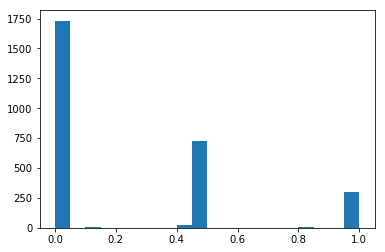

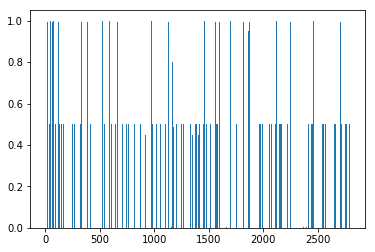

(2796, 2796, 2796)
(0.13274336283185842, 0.68877551020408168, 0.22258862324814513, None)
Optimization terminated successfully.
         Current function value: 4182.213294
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
[ 3.29293033  0.80240776  3.54276763  3.57746115  2.57487472  2.54625167
  4.16422647]
train iteration: 1


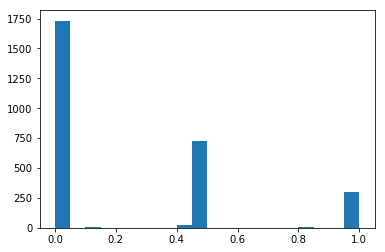

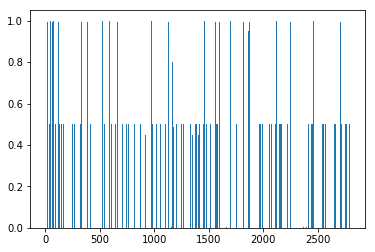

(2796, 2796, 2796)
(0.13274336283185842, 0.68877551020408168, 0.22258862324814513, None)
test:


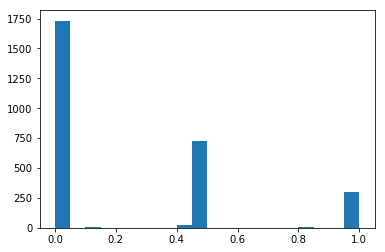

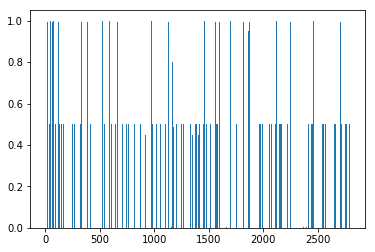

(2796, 2796, 2796)
(0.13274336283185842, 0.68877551020408168, 0.22258862324814513, None)


In [11]:
# All LF_Threshold =0.3 and softmax_Threshold=0.3 ,to be run
train(2,Use_Confidence=False,theta_file_name="THETA")

test(THETA)

In [ ]:
def print_details(label,THETA,LAMDA,SCORE):
    print(label)
    P_cap = get_P_cap(LAMDA,SCORE,THETA)
    marginals=get_marginals(P_cap)
    plt.hist(marginals, bins=20)
    plt.show()
    #plt.bar(range(0,2796),marginals)
    #plt.show()
    predicted_labels=predict_labels(marginals)
    print(len(marginals),len(predicted_labels),len(gold_labels_dev))
    #score(predicted_labels,gold_labels_dev)
    print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary')) 
    
def predict_labels(marginals):
    predicted_labels=[]
    for i in marginals:
        if(i<0.5):
            predicted_labels.append(-1)
        else:
            predicted_labels.append(1)
    return predicted_labels

#import cPickle as pickle
#THETA = pickle.load( open( "THETA.p", "rb" ) )
#test(THETA)
#LAMDA,SCORE = get_LAMDA(dev_cands)
#Confidence = get_Confidence(LAMDA)

#P_cap = get_P_cap(LAMDA,SCORE,THETA)
#marginals=get_marginals(P_cap)
#plt.hist(marginals, bins=20)
#plt.show()
#plt.bar(range(0,888),train_marginals)
#plt.show()

print_details("dev set",THETA,dev_LAMDA,dev_SCORE)
predicted_labels=predict_labels(marginals)


sorted_predicted_labels=[x for (y,x) in sorted(zip(Confidence,predicted_labels))] #sort Labels as per Confidence
sorted_predicted_labels=list(reversed(sorted_predicted_labels))


for i,j in enumerate(reversed(sorted(zip(Confidence,predicted_labels,gold_labels_dev)))):
    if i>20:
        break
    print i,j
#print(len(marginals),len(predicted_labels),len(gold_labels_dev))
#no_of_labels=186#int(len(predicted_labels)*0.1)  #54 - >0.2  , 108>= 0.15 , 186>= 0.12
#print(len(sorted_predicted_labels[0:no_of_labels]))
no_of_labels=2796
score(predicted_labels[0:no_of_labels],gold_labels_dev[0:no_of_labels])
